# Convolutional Neural Network for binary classification of spectrograms from 10 seconds fragments of audio recordings

Full audio recording from participants were sliced into 10 seconds fragments. This notebook converts each of those 10 seconds recordings into spectrograms and trains a convolutional neural network to classify those spectrograms into 2 classes (binary classification).

In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
# Set paths to input and output data, selecting the folder corresponding to the 10 seconds fragments
INPUT_DIR = 'audio_sliced/10s'
OUTPUT_DIR = 'spectrograms/10s'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in range(10):
    print(parent_list[i])

Import label for the data

In [3]:
data_labels = pd.read_csv('COVAREP_and_depression_data_mean.csv')

patientId = 300
data_labels['PHQ8_Binary'] = data_labels['PHQ8_Binary'].astype(int)
# print(int(data_labels.loc[data_labels['patientId'] == patientId, 'PHQ8_Binary'].values[0]))

labels = data_labels['PHQ8_Binary']

sum(labels)/len(labels)

0.2962962962962963

### Visualization of audio fragments

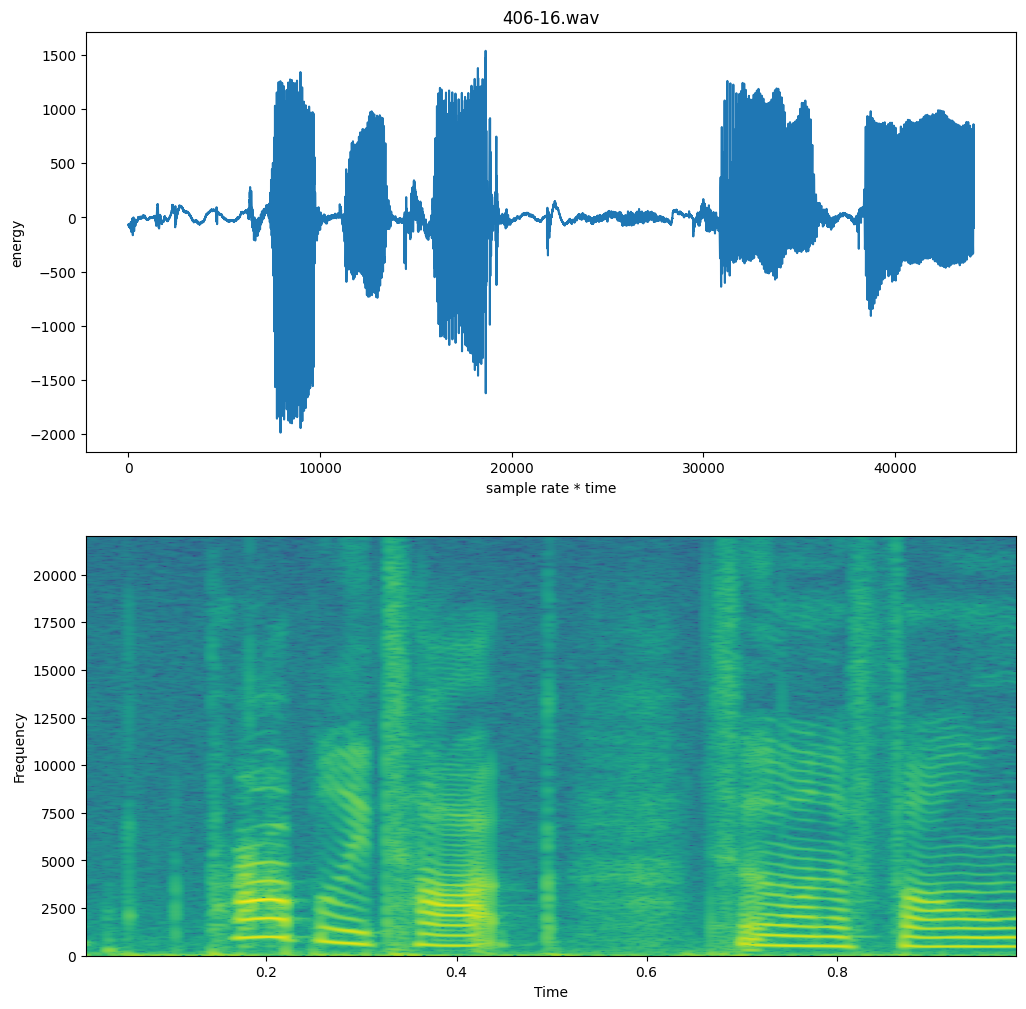

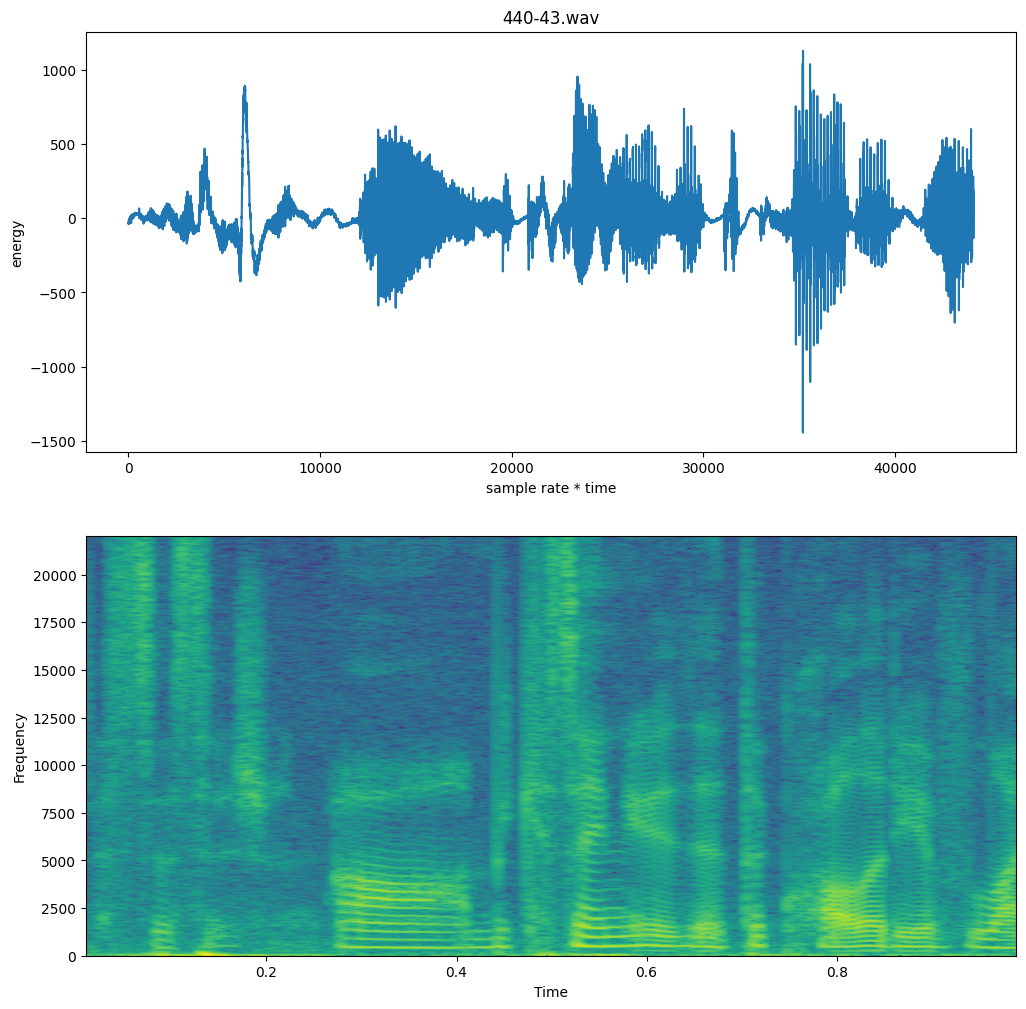

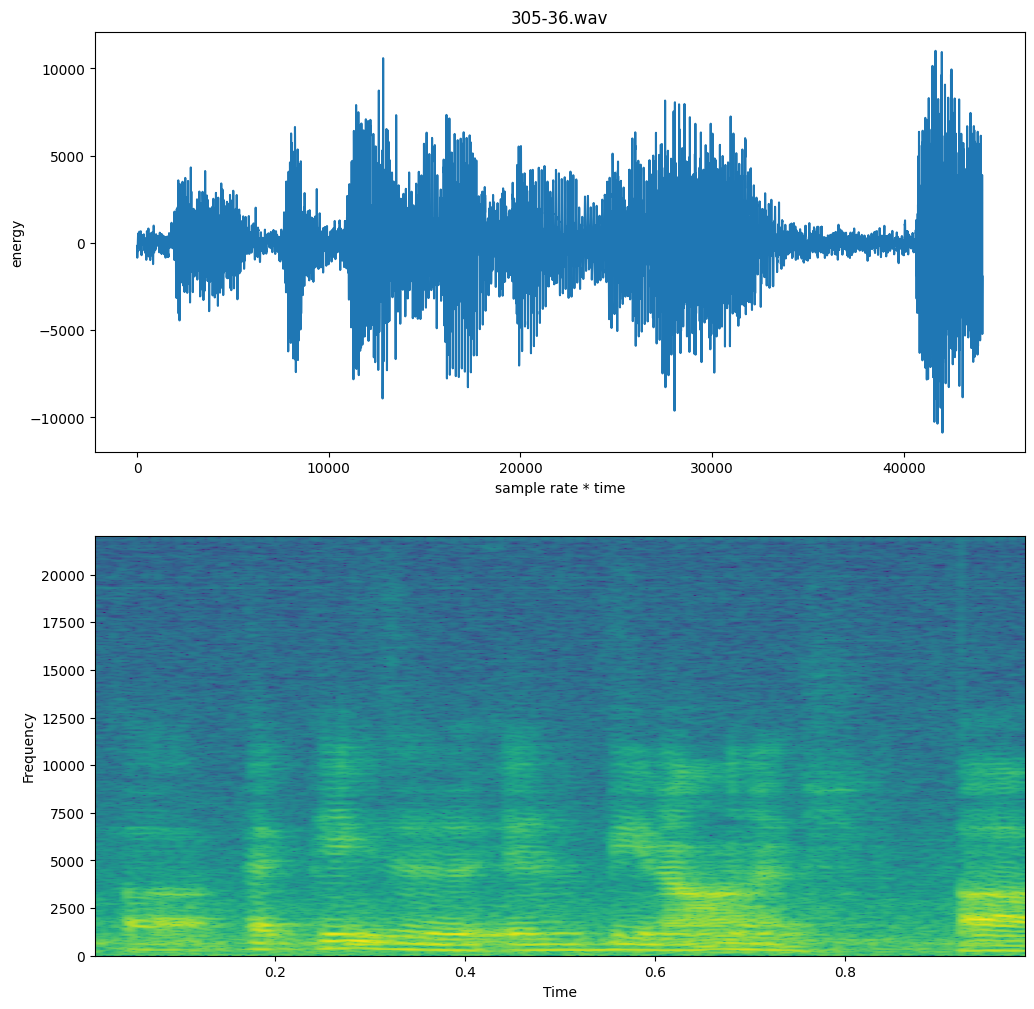

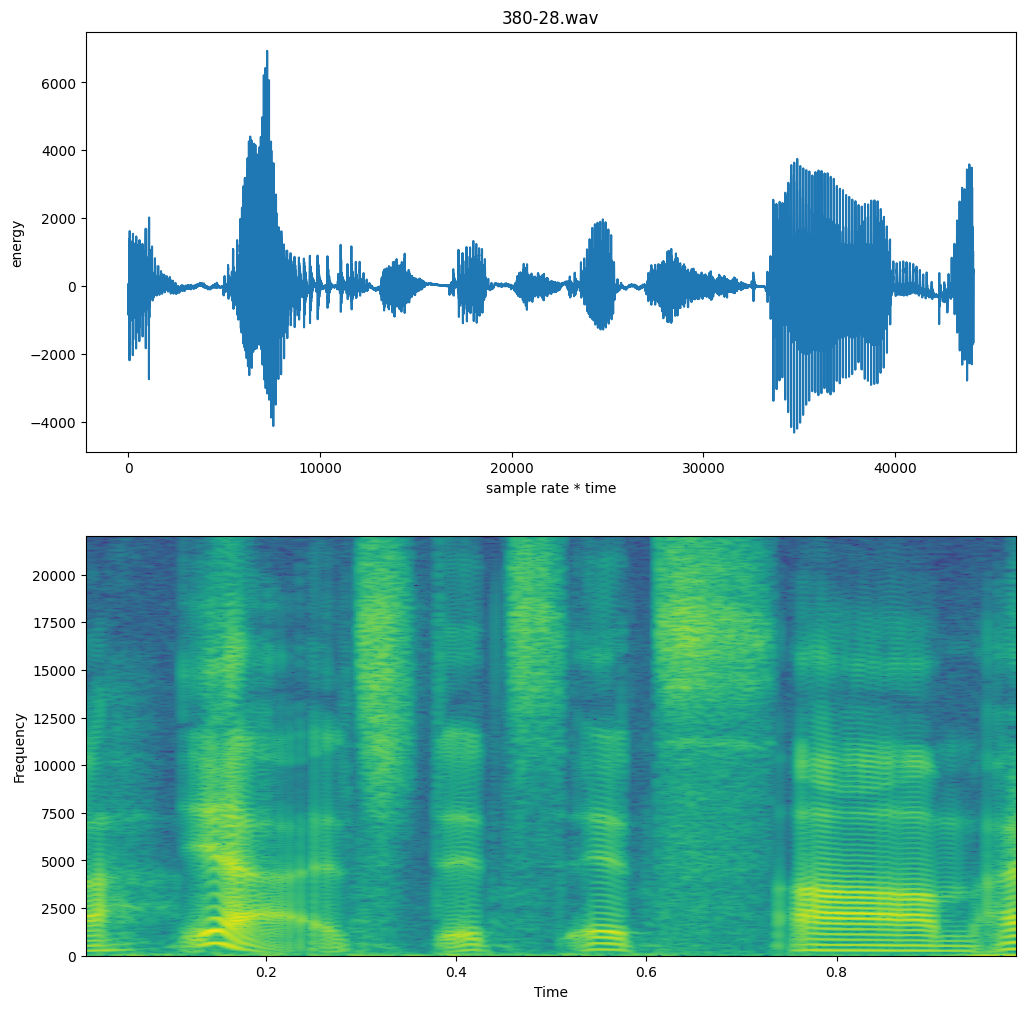

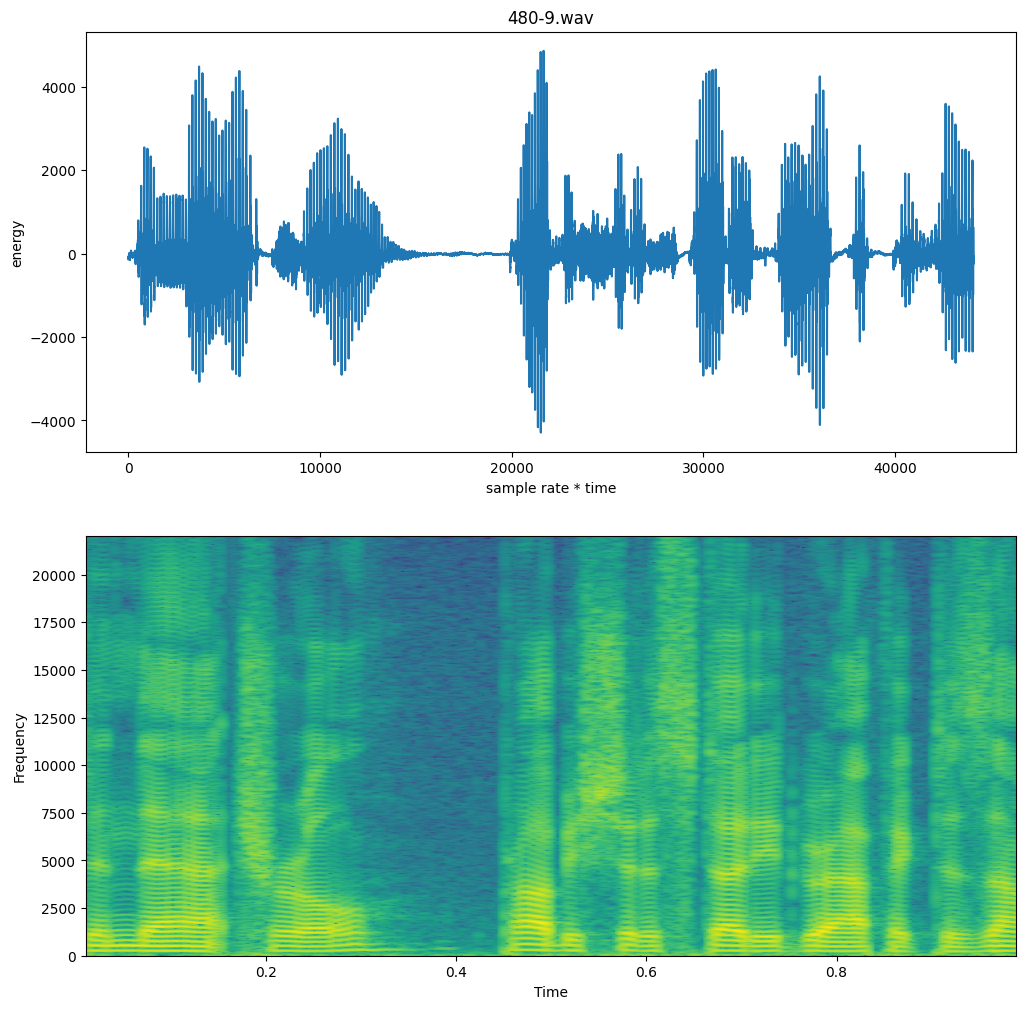

In [113]:
# Plot first 5 WAV files as a waveform and a frequency spectrum
for i in range(5): 
    signal_wave = wave.open(os.path.join(INPUT_DIR, parent_list[i]), 'r')
    sample_rate = 44100
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

### Processing of audio files into spectrograms

In [101]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR)):
    os.mkdir(os.path.join(OUTPUT_DIR))

# For each file in the input folder, create a spectrogram and export it into the output folder mantaining the participant id as name
for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR, filename)
        patientId = Path(file_path).stem
        patientIdint = int(patientId.split('-')[0])
        label_depression = int(data_labels.loc[data_labels['patientId'] == patientIdint, 'PHQ8_Binary'].values[0])
        target_dir = f'class_{label_depression}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR), target_dir)
        file_dist_path = os.path.join(dist_dir, patientId)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.axis('off')
            pylab.margins(0,0)
            pylab.savefig(f'{file_dist_path}.png', bbox_inches='tight', pad_inches = 0)
            pylab.close()



/Users/bruno/Documents/PsyVox/voice-depression/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7726: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


### Loading the data and declaring constants for training and testing

In [6]:
# Declare constants
IMAGE_HEIGHT = 256 #640
IMAGE_WIDTH = 256 #480
BATCH_SIZE = 64
N_CHANNELS = 3
N_CLASSES = 1
val_split = 0.3

OUTPUT_DIR = 'spectrograms/10s'

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = OUTPUT_DIR,
                                             batch_size=BATCH_SIZE,
                                             validation_split=val_split,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=10)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = OUTPUT_DIR,
                                             batch_size=BATCH_SIZE,
                                             validation_split=val_split,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=10)



Found 11295 files belonging to 2 classes.
Using 7907 files for training.
Found 11295 files belonging to 2 classes.
Using 3388 files for validation.


### Create the Convolutional Neural Network model

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(8, 5, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(12, 3, strides = 1, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(24, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='sigmoid'))


# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(
    # from_logits=True,
    label_smoothing=0.1,
    # axis=-1,
    # reduction="auto",
    name="binary_crossentropy",
),
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5), 
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            ],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 8)       608       
                                                                 
 batch_normalization_7 (Batc  (None, 128, 128, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 12)        876       
                                                      

In [8]:
# For balancing the data we assign class weights to improve performance by telling the model to assign more weight to the less represented class
class_weights = {
  0: 0.30,
  1: 0.70,
}

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=30, validation_data=valid_dataset, class_weight=class_weights)

Epoch 1/30
124/124 [==============================] - 182s 1s/step - loss: 0.3861 - binary_accuracy: 0.5149 - auc_1: 0.5272 - precision_1: 0.4844 - recall_1: 0.6062 - val_loss: 0.7291 - val_binary_accuracy: 0.5015 - val_auc_1: 0.5431 - val_precision_1: 0.4780 - val_recall_1: 0.8242
Epoch 2/30
124/124 [==============================] - 167s 1s/step - loss: 0.3473 - binary_accuracy: 0.5471 - auc_1: 0.5668 - precision_1: 0.5122 - recall_1: 0.6322 - val_loss: 0.6825 - val_binary_accuracy: 0.5629 - val_auc_1: 0.5922 - val_precision_1: 0.5308 - val_recall_1: 0.4892
Epoch 3/30
124/124 [==============================] - 130s 1s/step - loss: 0.3362 - binary_accuracy: 0.5544 - auc_1: 0.5924 - precision_1: 0.5174 - recall_1: 0.6804 - val_loss: 0.6780 - val_binary_accuracy: 0.5841 - val_auc_1: 0.6236 - val_precision_1: 0.5419 - val_recall_1: 0.6624
Epoch 4/30
124/124 [==============================] - 162s 1s/step - loss: 0.3235 - binary_accuracy: 0.5823 - auc_1: 0.6302 - precision_1: 0.5381 - rec

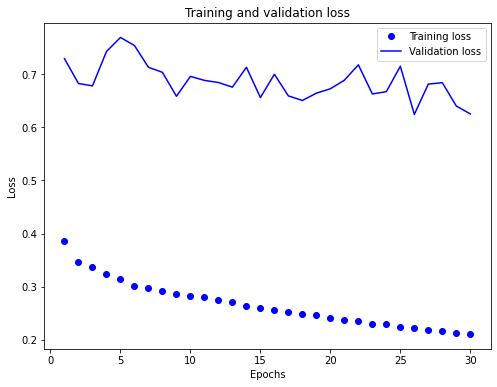

In [9]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

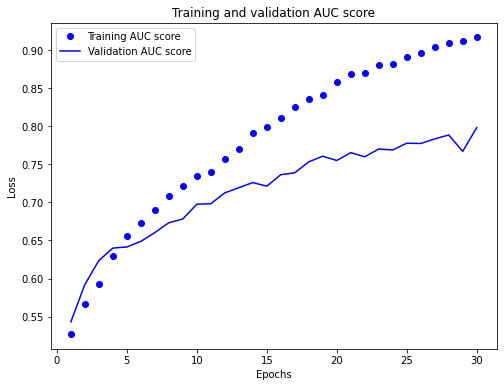

In [10]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['auc_1']
val_loss_values = history_dict['val_auc_1']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training AUC score')
plt.plot(epochs, val_loss_values, 'b', label='Validation AUC score')
plt.title('Training and validation AUC score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
model.evaluate(valid_dataset)

53/53 [==============================] - 26s 432ms/step - loss: 0.6252 - binary_accuracy: 0.6851 - auc_1: 0.7980 - precision_1: 0.6062 - recall_1: 0.9146


[0.6252154111862183,
 0.6850649118423462,
 0.7980348467826843,
 0.606162965297699,
 0.9146496653556824]

In [129]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.595279, final accuracy: 0.741145


In [130]:
predicted_probs2 = model.predict(valid_dataset)
predicted_probs = predicted_probs>=0.5
y = np.concatenate([y for x, y in valid_dataset], axis=0)

print(y[0:20])
print(predicted_probs2[0:20])
print(sum(predicted_probs))

106/106 [==============================] - 5s 40ms/step
[0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0]
[[0.72870976]
 [0.8626487 ]
 [0.7827252 ]
 [0.2631674 ]
 [0.98654395]
 [0.4960212 ]
 [0.76309663]
 [0.16351902]
 [0.9362241 ]
 [0.41709682]
 [0.4079027 ]
 [0.4838369 ]
 [0.7662487 ]
 [0.831174  ]
 [0.88505286]
 [0.96765625]
 [0.38639778]
 [0.79348165]
 [0.34304243]
 [0.17759466]]
[1]
